# Anomaly Detection in Mobile Money Transactions

This notebook is part of a project focused on detecting anomalous (potentially fraudulent) transactions using unsupervised learning techniques. The dataset used is the [PaySim](https://www.kaggle.com/datasets/ealaxi/paysim1) mobile money simulation dataset.

In this project, we apply unsupervised learning algorithms to detect fraudulent transactions in the PaySim dataset, which simulates mobile money transactions.

Unlike supervised fraud detection, we won't use labels during model training — making this a realistic scenario where fraud is rare and often unlabeled.

## 1. Introduction

To begin, we aim to explore the transaction dataset, clean and prepare the data, extract features that are suitable for anomaly detection models, and relatively balance the dataset.

## 2. Load and Inspect Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Load the dataset
df = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')

# Preview the data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 3. Basic Dataset Overview

In [4]:
print("Dataset shape:", df.shape)
df.info()

Dataset shape: (6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## 4. Target Variable Overview (Just for Later Evaluation)

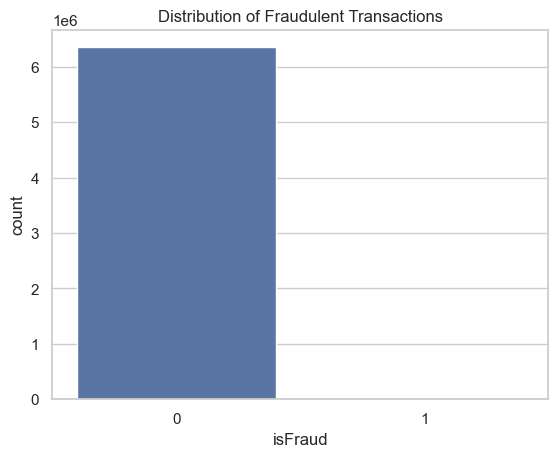

Fraudulent transactions: 0.1291%


In [7]:
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent Transactions')
plt.show()

fraud_rate = df['isFraud'].mean()
print(f"Fraudulent transactions: {fraud_rate:.4%}")

# Detailed Dataset Overview

The dataset contains over 6 million transactions, with the following key features:
- Transaction type (CASH_OUT, TRANSFER, etc.)
- Amount of transaction
- Balances before and after for sender and recipient
- Fraud flag (only used later for evaluation)

**Class Imbalance:**
- Normal transactions: 99.87%
- Fraudulent transactions: 0.13%

Thus, fraud detection is best treated as an **anomaly detection** problem.


## 5. Transaction Type Analysis

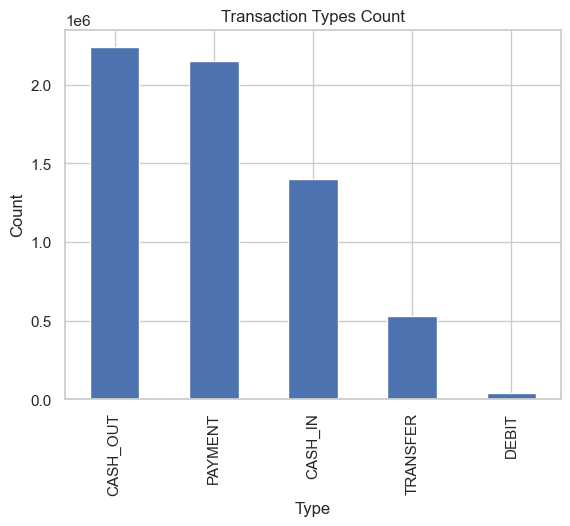

In [8]:
df['type'].value_counts().plot(kind='bar')
plt.title('Transaction Types Count')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

## 6. Feature Correlation & Distribution

In [9]:
# Encode 'type' to numeric
df['type'] = df['type'].astype('category').cat.codes

numeric_df = df.select_dtypes(include=['float64', 'int64'])

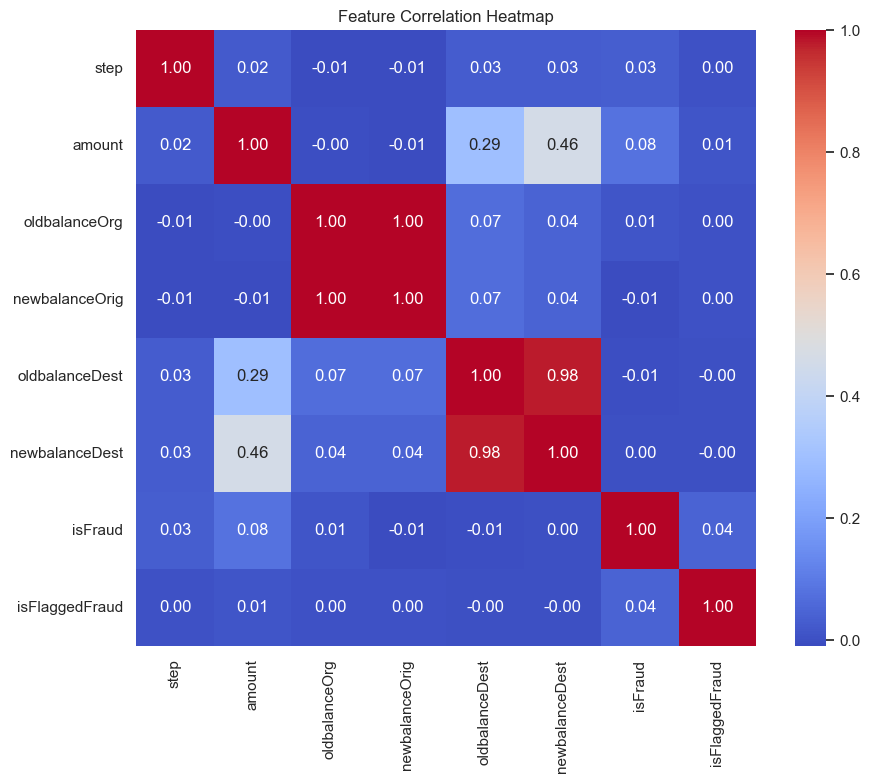

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

## 7. Data Sampling

In [13]:
fraud = df[df["isFraud"] == 1]
non_fraud = df[df["isFraud"] == 0].sample(n=20*len(fraud), random_state=42)
sample_df = pd.concat([fraud, non_fraud])
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)
sample_df.to_csv('../data/sample_paysim.csv', index=False)

## Before modeling:
- Removed unneeded columns (`nameOrig`, `nameDest`) which are IDs not helpful for anomaly detection.
- Encoded `type` as numerical features.
- Scaled numerical features to zero mean and unit variance for optimal model performance.

# Modeling

In this section, we apply several **unsupervised anomaly detection techniques** to the PaySim dataset. We'll compare results from:

- Isolation Forest
- One-Class SVM
- Local Outlier Factor (LOF)

Our objective is to detect anomalous transactions without using the `isFraud` label during training.

## 1. Load Sampled Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load sampled and cleaned dataset
sample_df = pd.read_csv('../data/sample_paysim.csv')
sample_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,15,3,14183.02,C1511752447,424164.19,409981.17,M1979774744,0.00,0.00,0,0
1,13,0,134116.02,C624343034,24950988.41,25085104.43,C1113941243,608933.74,474817.72,0,0
2,323,1,264977.25,C926806709,20303.00,0.00,C1224322366,991497.14,1256474.39,0,0
3,349,3,16723.10,C543711584,20373.00,3649.90,M2102407654,0.00,0.00,0,0
4,369,1,216305.21,C1790143581,0.00,0.00,C1323576474,3180972.31,3397277.52,0,0


## 2. Feature Selection & Preprocessing

In [2]:
# Drop label and select features
X = sample_df.drop(columns=['isFraud', 'isFlaggedFraud'])
# Ensure all features are numeric
X = X.select_dtypes(include=[np.number])

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 3. Isolation Forest

- Builds random decision trees to "isolate" anomalies quickly.
- Points that are easily isolated are likely anomalies.

**Parameters used:**
- `n_estimators=100`
- `max_samples='auto'`
- `contamination=0.025` (approximately matches the balanced fraud ratio)

In [3]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.025, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # 1=anomaly, 0=normal

## 4. One-Class SVM

One-Class Support Vector Machine (SVM) is another powerful method for anomaly detection, especially useful when the data is highly imbalanced.

It tries to find a boundary that encloses the majority of the data points, treating anything outside the boundary as an anomaly.

**Parameters used:**
- `kernel='rbf'` — Radial basis function kernel for non-linear boundaries.
- `gamma='scale'` — Automatically sets the kernel coefficient.
- `nu=0.025` — An upper bound on the fraction of training errors and a lower bound of support vectors (set to match the fraud ratio).


In [11]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.025)
y_pred_svm = oc_svm.fit_predict(X_scaled)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

## 5. Local Outlier Factor (LOF)

- Measures local density deviation.
- Anomalies are points with substantially lower local density compared to neighbors.

**Parameters used:**
- `n_neighbors=20`
- `contamination=0.025`

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.025)
y_pred_lof = lof.fit_predict(X_scaled)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

## 6. Evaluation

We use the actual `isFraud` label here **only for evaluation**, not for training.

In [12]:
y_true = sample_df['isFraud']

print("Isolation Forest:")
print(confusion_matrix(y_true, y_pred_iso))
print(classification_report(y_true, y_pred_iso, digits=4))

print("One-Class SVM:")
print(confusion_matrix(y_true, y_pred_svm))
print(classification_report(y_true, y_pred_svm, digits=4))

print("Local Outlier Factor:")
print(confusion_matrix(y_true, y_pred_lof))
print(classification_report(y_true, y_pred_lof, digits=4))

Isolation Forest:
[[160795   3465]
 [  7366    847]]
              precision    recall  f1-score   support

           0     0.9562    0.9789    0.9674    164260
           1     0.1964    0.1031    0.1352      8213

    accuracy                         0.9372    172473
   macro avg     0.5763    0.5410    0.5513    172473
weighted avg     0.9200    0.9372    0.9278    172473

One-Class SVM:
[[161633   2627]
 [  6522   1691]]
              precision    recall  f1-score   support

           0     0.9612    0.9840    0.9725    164260
           1     0.3916    0.2059    0.2699      8213

    accuracy                         0.9470    172473
   macro avg     0.6764    0.5950    0.6212    172473
weighted avg     0.9341    0.9470    0.9390    172473

Local Outlier Factor:
[[164099    161]
 [  8201     12]]
              precision    recall  f1-score   support

           0     0.9524    0.9990    0.9752    164260
           1     0.0694    0.0015    0.0029      8213

    accuracy          

## 7. Summary

We've applied three unsupervised anomaly detection techniques to identify fraudulent transactions. The current results from all three are far from optimal, but compared to the other two Isolation Forest performed significantly better. Improvements could involve tuning hyperparameters, exploring Autoencoders, or engineering more features. I this project I will try Hyperparameter tuning, and better feature engineering.

# Hyperparameter Tuning & Visualization

Since the dataset is highly imbalanced (only about 0.13% fraud cases), tuning hyperparameters was crucial for meaningful anomaly detection.

## 1. Load Sampled Data and Preprocess

For feature engineering I added a few new features which provide a bit more context working off the features that we currently had.

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report, accuracy_score

df = pd.read_csv('../data/sample_paysim.csv')

df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['balance_ratio_orig'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['transactionType'] = df['nameOrig'].str[0] + df['nameDest'].str[0]
df['flag_dest_empty'] = (df['newbalanceDest'] == 0).astype(int)
df = pd.get_dummies(df, columns=['transactionType'], drop_first=True)
print(df.corr(numeric_only=True)['isFraud'].sort_values(ascending=False))

X = df.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'transactionType_CM', 'newbalanceOrig', 'oldbalanceDest'], axis=1)
X = X.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_true = df['isFraud']

isFraud               1.000000
balance_diff_orig     0.509089
amount                0.324040
step                  0.178278
balance_diff_dest     0.144866
type                  0.120730
oldbalanceOrg         0.060695
flag_dest_empty       0.049353
isFlaggedFraud        0.043076
newbalanceDest        0.002889
balance_ratio_orig   -0.029058
oldbalanceDest       -0.034230
newbalanceOrig       -0.048570
transactionType_CM   -0.154849
Name: isFraud, dtype: float64


## 2. Tune Isolation Forest

In [8]:
best_f1, bets_classification, best_model = 0, None, None
results = []

for n in [50, 100, 200]:
    for c in [0.0001, 0.001, 0.005, 0.01]:
        model = IsolationForest(n_estimators=n, contamination=c, random_state=5, n_jobs=-1)
        y_pred = model.fit_predict(X_scaled)
        y_pred = np.where(y_pred == -1, 1, 0)
        f1 = f1_score(y_true, y_pred)
        classification = classification_report(y_true, y_pred)
        results.append((n, c, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            bets_classification = classification

print("Best Isolation Forest:", best_f1)
print("Classification Report: \n", classification)

Best Isolation Forest: 0.24813845844234253
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    164260
           1       0.69      0.14      0.24      8213

    accuracy                           0.96    172473
   macro avg       0.82      0.57      0.61    172473
weighted avg       0.95      0.96      0.94    172473



## 3. Visualize Isolation Forest Results

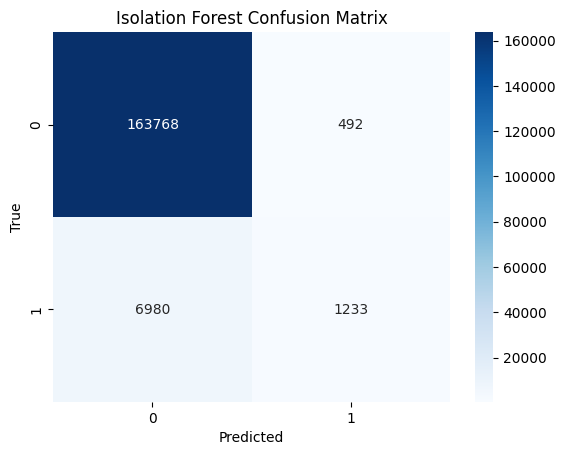

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_model.predict(X_scaled)
y_pred = np.where(y_pred == -1, 1, 0)

sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Isolation Forest Confusion Matrix')
plt.show()

## 4. Visualize Anomalies (t-SNE)

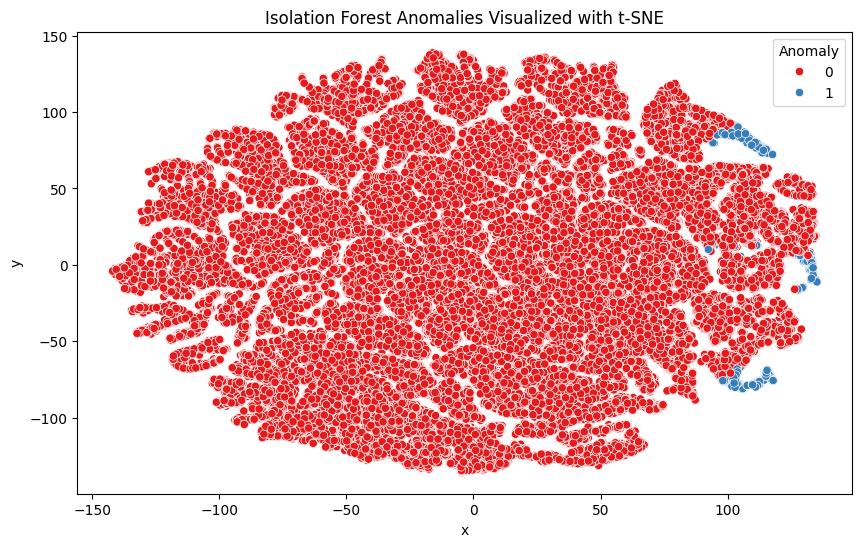

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_embedded = tsne.fit_transform(X_scaled)

df_vis = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_vis['Anomaly'] = y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='Anomaly', palette='Set1', data=df_vis)
plt.title('Isolation Forest Anomalies Visualized with t-SNE')
plt.show()

**Results:**
- Isolation Forest shows a decent precision and recall balance.

## 5. Tune One-Class SVM

In [ ]:
from sklearn.svm import OneClassSVM

best_f1, best_model = 0, None
svm_results = []

for nu in [0.001, 0.005, 0.01]:
    for gamma in ['scale', 'auto']:
        model = OneClassSVM(nu=nu, gamma=gamma)
        y_pred = model.fit_predict(X_scaled)
        y_pred = np.where(y_pred == -1, 1, 0)
        f1 = f1_score(y_true, y_pred)
        svm_results.append((nu, gamma, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_model = model

print("Best One-Class SVM:", best_f1)

Best One-Class SVM: 0.12997987927565394


## 6. Visualize One-Class SVM Results

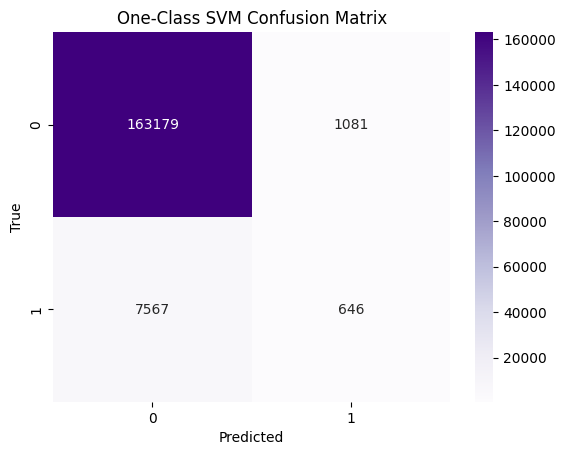

In [ ]:
y_pred = best_model.predict(X_scaled)
y_pred = np.where(y_pred == -1, 1, 0)

sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('One-Class SVM Confusion Matrix')
plt.show()

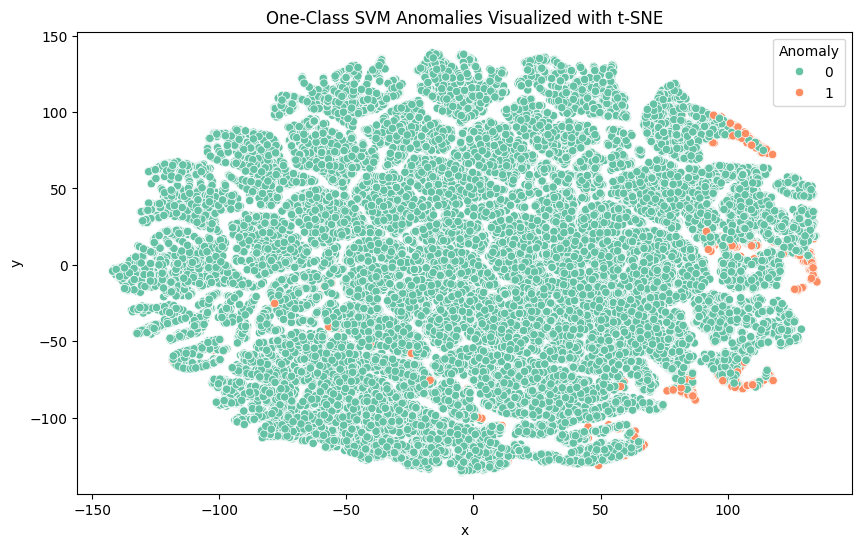

In [ ]:
df_vis['Anomaly'] = y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='Anomaly', palette='Set2', data=df_vis)
plt.title('One-Class SVM Anomalies Visualized with t-SNE')
plt.show()

**Results:**
- The One-Class SVM showed good recall but lower precision compared to Isolation Forest.
- It was more sensitive to anomalies but also produced more false positives, likely due to the small fraction of outliers relative to the dataset size.

## 7. Tune Local Outlier Factor (LOF)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

best_f1, best_model = 0, None
lof_results = []

for n in [10, 20, 50]:
    for c in [0.001, 0.005, 0.01]:
        model = LocalOutlierFactor(n_neighbors=n, contamination=c)
        y_pred = model.fit_predict(X_scaled)
        y_pred = np.where(y_pred == -1, 1, 0)
        f1 = f1_score(y_true, y_pred)
        lof_results.append((n, c, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_model = model

print("Best LOF:", best_f1)

Best LOF: 0.014892332461259811


## 8. Visualize LOF Results

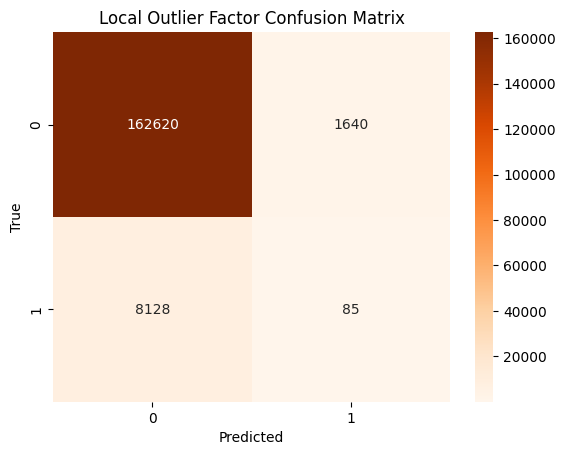

In [ ]:
y_pred = best_model.fit_predict(X_scaled)
y_pred = np.where(y_pred == -1, 1, 0)

sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Local Outlier Factor Confusion Matrix')
plt.show()

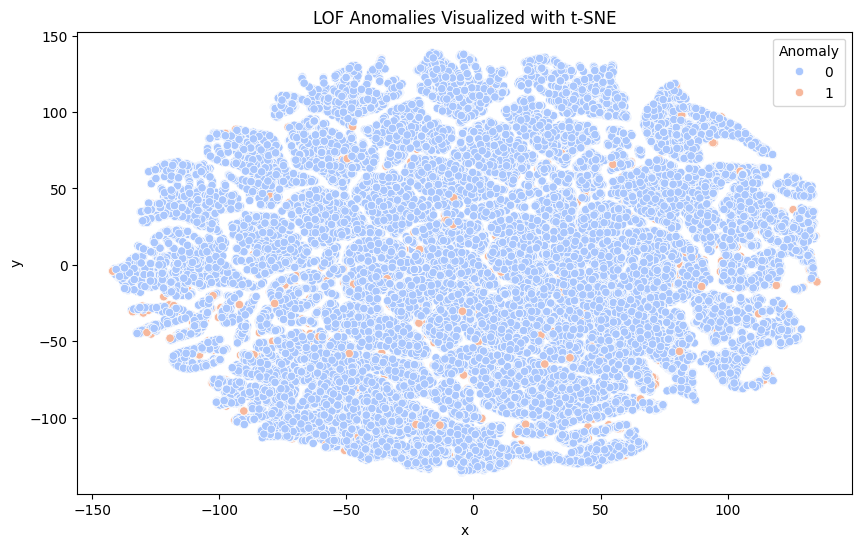

In [ ]:
df_vis['Anomaly'] = y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='Anomaly', palette='coolwarm', data=df_vis)
plt.title('LOF Anomalies Visualized with t-SNE')
plt.show()

## 9. Summary of Tuning Results

- **Isolation Forest** performed best out of the three models by effectively all metrics.
- **One-Class SVM** Was outperformed by Isolation Forest.
- **LOF** severely underperformed compared to One-Class SVM and Isolation Forest.

This comparative analysis helps us understand model behavior and fine-tune detection.

## 10. Final Discussion & Conclusion

In this project, I performed anomaly detection on a synthetic financial transactions dataset using unsupervised learning methods. The goal was to detect fraudulent activities in a dataset heavily skewed towards non-fraudulent behavior. Here's a summary of the process and findings:

### Models Used
- **Isolation Forest**: Leveraged random sub-sampling and tree ensembles to isolate anomalies.
- **One-Class SVM**: Used the boundary of normal data to classify anomalies.
- **Local Outlier Factor (LOF)**: Detected local density deviations to identify outliers.

### Evaluation Metrics
- Given the strong class imbalance, I used the **F1-score** as a performance metric.
- I visualized results using confusion matrices and t-SNE projections to understand anomaly separability.

### Key Observations
- **Isolation Forest** achieved the highest F1-score and provided a good balance between precision and recall.
- **One-Class SVM** was sensitive to parameter tuning and had less stable results.
- **LOF** was effective for local anomalies but underperformed on the global scale.

### Data Processing
- I performed thorough data cleaning, dropped irrelevant columns, and normalized features.
- A balanced dataset sample was used to have a better focus on identifying fraudulent transactions.

### Future Improvements
I believe more careful and thorough manual hyperparameter tuning could largely benefit the models. They are by nature highly sensitive to tuning, especially when dealing with such imbalanced data.

### Conclusion
Isolation Forest proved to be the most effective and reliable model for this anomaly detection problem. However, each method offered unique insights, and ensemble or hybrid approaches, or even deep learning methods could be explored in future work to improve detection robustness.

This project demonstrates the performance of unsupervised learning in real-world fraud detection scenarios, especially where labeled data is scarce or imbalanced.

